# EMRI Waveforms

In [1]:
import time
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

from lisatools.diagnostic import *
from lisatools.sensitivity import get_sensitivity

from few.waveform import GenerateEMRIWaveform
from few.utils.constants import *
from few.utils.utility import *
from few.trajectory.inspiral import EMRIInspiral
traj_module = EMRIInspiral(func="KerrEccEqFlux")
from few.trajectory.ode.flux import KerrEccEqFlux

from scipy.signal.windows import tukey, hann, boxcar, nuttall, blackman
from few.utils.fdutils import *

from fastlisaresponse import pyResponseTDI, ResponseWrapper
from lisatools.detector import EqualArmlengthOrbits, ESAOrbits

import warnings
warnings.filterwarnings("ignore")

In [2]:
use_gpu = False

##### Initialize the generators

In [3]:
metric = "FastKerrEccentricEquatorialFlux"   # Kerr
#metric = "FastSchwarzschildEccentricFlux"    # Schw

few_gen = GenerateEMRIWaveform(
    metric,
    sum_kwargs=dict(pad_output=True, output_type="fd", odd_len=True),
    return_list=False,
)

td_gen = GenerateEMRIWaveform(
    metric,
    sum_kwargs=dict(pad_output=True, odd_len=True),
    return_list=False,
)

Set the values of the parameters

In [4]:
# Define injection parameters
M = 1e6  # central object mass
a = 0.9  # spin (will be ignored in Schwarzschild waveform)
mu = 1e2  # secondary object mass
p0 = 12.0  # initial semi-latus rectum
e0 = 0.7  # eccentricity
x0 = 1.0  # cosine of inclination (will be ignored in Schwarzschild waveform)

qK = np.pi / 3  # polar spin angle (theta)    --> tilt w/ respect to horizontal
phiK = np.pi / 3  # azimuthal viewing angle
qS = np.pi / 3  # polar sky angle             --> location in the sky
phiS = np.pi / 3  # azimuthal viewing angle
dist = 0.1  # distance

# initial phases
Phi_phi0 = np.pi / 3
Phi_theta0 = 0.0
Phi_r0 = np.pi / 3



Tobs = 1  # observation time, if the inspiral is shorter, the it will be zero padded
dt = 10.0  # cadence
eps = 1e-4  # mode content percentage

waveform_kwargs = {
    "T": Tobs,
    "dt": dt,
    "eps": eps,
}


# get the initial p0 
p0 = get_p_at_t(
    traj_module,
    Tobs*0.99,
    [M, mu, 0.0, e0, 1.0],
    index_of_p=3,
    index_of_a=2,
    index_of_e=4,
    index_of_x=5,
    traj_kwargs={},
    xtol=2e-12,
    rtol=8.881784197001252e-16,
    bounds=None,
)


emri_injection_params = [
    M,
    mu,
    a,
    p0,
    e0,
    x0,
    dist,
    qS,
    phiS,
    qK,
    phiK,
    Phi_phi0,
    Phi_theta0,
    Phi_r0,
]

print(p0)

13.781621378516354


Define parameters for LISA response

In [5]:
tdi_kwargs_esa = dict(
        Tobs=Tobs,
        dt=dt,
        t0 = 10000.0,  # time at which signal starts (chops off data at start and end of waveform)
        order = 25, # order of the langrangian interpolation (for strain and orbits?)
        index_beta = 7,   # Sky location parameters: theta --> qS
        index_lambda = 8, #                          phi --> phiS
        tdi="1st generation", 
        tdi_chan="AET",
        orbits=ESAOrbits(),
    )

In [6]:
def fastlisaresponse(metric, *emri_injection_params, waveform_kwargs=None, tdi_kwargs_esa=None):
    waveform_kwargs = waveform_kwargs or {}
    tdi_kwargs_esa = tdi_kwargs_esa or {}
    
    # Wave generator
    td_gen = GenerateEMRIWaveform(
        metric,
        sum_kwargs=dict(pad_output=True, odd_len=True),
        return_list=False,
    )

    # Initialize the response wrapper
    gb_lisa_esa = ResponseWrapper(
        waveform_gen=td_gen, 
        flip_hx=True, # set to True if waveform is h+ - ihx
        use_gpu=use_gpu,
        remove_sky_coords=False, # True if the waveform generator does not take sky coordinates
        is_ecliptic_latitude=False, # True if using ecliptic coordinates (here SSB)
        remove_garbage=True, # removes the beginning of the signal that has bad information
        **tdi_kwargs_esa,
    )

    return gb_lisa_esa(*emri_injection_params, **waveform_kwargs)


In [7]:
chans = fastlisaresponse(
    metric,
    *emri_injection_params,
    waveform_kwargs=waveform_kwargs,
    tdi_kwargs_esa=tdi_kwargs_esa
)

### Noise in frequency domain

Define the function that generates the noise in frequency domain (different gaussian realisation with sigma 
for the real and imaginary part fo the FD signal)

In [8]:
def generate_frequency_domain_noise_lisa(psd_pos, dt, N_obs):
    
    sigma = 0.5 * (psd_pos / (1.0 / (N_obs * dt))) ** 0.5

    noise = np.random.normal(0.0, sigma) + 1j * np.random.normal(0.0, sigma)

    return noise

Generate FD signal

In [9]:
fft_TD = np.fft.rfft(chans[0]) * dt
N_obs = len(chans[0])
freq = np.fft.rfftfreq(len(chans[0]), dt)
    
# define the non-zero frequencies
positive_frequency_mask = (freq>0.0)
    
# you can specify the frequencies or obtain them directly from the waveform
fd_kwargs = waveform_kwargs.copy()
fd_kwargs['f_arr'] = freq   # otherwise specify here
fd_kwargs['mask_positive']=True

hf = fft_TD[positive_frequency_mask]

Generate FD noise and add it to the FD signal

In [10]:
# generate psd, ONLY for non-negative frequencies
pos_psd = get_sensitivity(freq[positive_frequency_mask], sens_fn='A1TDISens')

# add noise to signal
hf_noise = hf + generate_frequency_domain_noise_lisa(pos_psd, dt, N_obs)

print('FD noise: ', hf_noise)

FD noise:  [ 1.27790831e-14+1.71033512e-14j -4.79152460e-15-4.05967316e-14j
  2.34671900e-14-1.74065897e-15j ... -9.30695300e-17-3.17766776e-17j
  5.87548648e-17-4.05677277e-17j  2.90794268e-17+4.67067340e-17j]


Note: PSD at freq=0 is inf. Here shouldn't be a problem but I have to address it for TD (I think).

Plot in characteristic strain representation

$$ h_c^2 = 4 f^2 |\tilde{h}(f)|^2 $$
$$ h_n^2= f S_n(f) $$

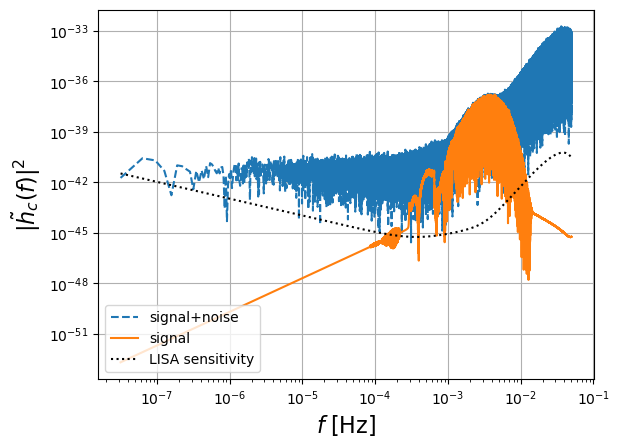

In [11]:
plt.loglog(freq[positive_frequency_mask], 4 * freq[positive_frequency_mask] **2 * np.abs(hf_noise) **2 ,'--',label='signal+noise')
plt.loglog(freq[positive_frequency_mask], 4 * freq[positive_frequency_mask] **2 * np.abs(hf) **2,label='signal')
plt.loglog(freq[positive_frequency_mask], pos_psd*freq[positive_frequency_mask],'k:',label='LISA sensitivity')
plt.ylabel(r'$| \tilde{h}_c (f)|^2$',fontsize=16)
plt.grid()
plt.xlabel(r'$f$ [Hz]',fontsize=16)
plt.legend(loc='lower left')
#plt.ylim([0.5e-48, 1e-25])
plt.show()

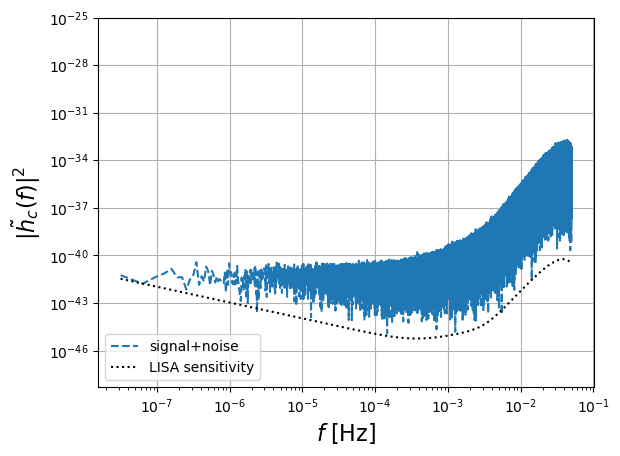

In [12]:
plt.loglog(freq[positive_frequency_mask], 4 * freq[positive_frequency_mask] **2 * np.abs(generate_frequency_domain_noise_lisa(pos_psd, dt, N_obs)) **2 ,'--',label='signal+noise')
#plt.loglog(freq[positive_frequency_mask], 4 * freq[positive_frequency_mask] **2 * np.abs(hf) **2,label='signal')
plt.loglog(freq[positive_frequency_mask], pos_psd*freq[positive_frequency_mask],'k:',label='LISA sensitivity')
plt.ylabel(r'$| \tilde{h}_c (f)|^2$',fontsize=16)
plt.grid()
plt.xlabel(r'$f$ [Hz]',fontsize=16)
plt.legend(loc='lower left')
plt.ylim([0.5e-48, 1e-25])
plt.show()

### Noise in Time Domain

Define the function that generates the noise in TD:
- two gaussian realizations, one for real and one for imaginary part of FD noise
- real inverse FFT for this complex FD noise $\to$ TD noise
- repeat this two times, one for the real (+) and one for the imaginary ($\times$) part of TD signal

##### NB: I'm using the PSD only for frequencies bigger than 5e-4

In [13]:
def generate_time_domain_noise_lisa(pos_psd, dt, N_obs):
    
    sigma = 0.5 * (pos_psd / (1.0 / (N_obs * dt))) ** 0.5
    
    noise_real = np.random.normal(0.0, sigma) + 1j * np.random.normal(0.0, sigma)
    
    noise_time_domain = np.fft.irfft(noise_real, n=N_obs) / dt
    print('noise_time_domain: ', noise_time_domain)
    
    return noise_time_domain

In [14]:
# generate TD signal
time_array = np.arange(0,len(chans[0]))*dt
N_obs = len(chans[0])

# generate the frequecies (ascending order) 
freq = np.fft.rfftfreq(len(chans[0]), dt)
print('freq: ', freq)

# find the positive (non-negative) frequencies
positive_frequency_mask = (freq>0)

freq:  [0.00000000e+00 3.17076403e-08 6.34152807e-08 ... 4.99999366e-02
 4.99999683e-02 5.00000000e-02]


Generate TD noise and add it to the TD signal

In [15]:
# generate psd, ONLY for non-negative frequencies
#pos_psd = get_sensitivity(freq[positive_frequency_mask], return_type="PSD")

# generate two realizations for the noise, one for real and one for imaginary part
noise_td_re = generate_time_domain_noise_lisa(pos_psd, dt, N_obs)
#noise_td_im = generate_time_domain_noise_lisa(pos_psd, dt, N_obs)

# add TD noise to TD signal
#data_channels_td_noise = chans[0] + (noise_td_re + 1j * noise_td_im)
data_channels_td_noise = chans[0] + noise_td_re 

print(data_channels_td_noise)

noise_time_domain:  [-1.34767019e-21  9.78423158e-21 -3.12838217e-22 ...  1.81661443e-21
  1.04127408e-21 -2.29522455e-21]
[-1.35094851e-21  9.77812431e-21 -3.20792850e-22 ...  1.12853177e-21
  5.63146051e-22 -2.49823847e-21]


Plot only the noise

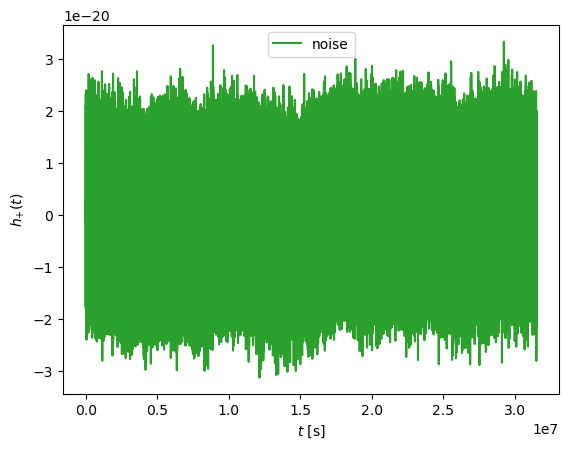

In [16]:
plt.plot(time_array, noise_td_re, label='noise', c='C2')
plt.ylabel(r'$h_{+}(t)$')
plt.xlabel(r'$t$ [s]')

t0 = time_array[-1]*0.7
space_t = 1.3*10e3
#plt.xlim([t0,(t0+space_t)])
#plt.ylim([4.22e-17, 4.26e-17])
#plt.ylim([-1.275e-17, -1.25e-9])
plt.legend(loc='upper center')
plt.show()

Plot of + polarization signal (real part of signal) 

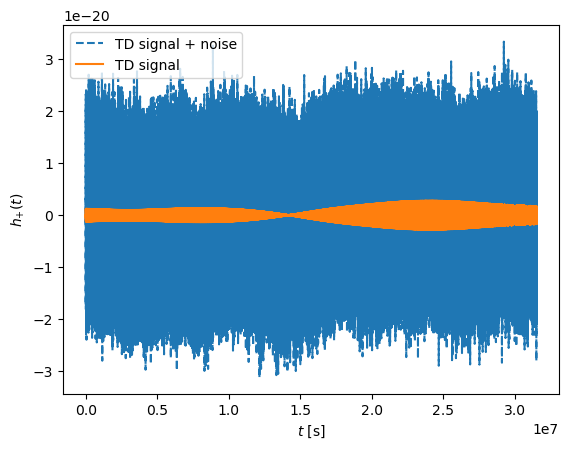

In [17]:
plt.plot(time_array, data_channels_td_noise.real,'--' ,label='TD signal + noise')
plt.plot(time_array, chans[0],label='TD signal')
plt.ylabel(r'$h_{+}(t)$')
plt.xlabel(r'$t$ [s]')

t0 = time_array[-1]*0.7
space_t = 1.3*10e3
#plt.xlim([t0,(t0+space_t)])
#plt.ylim([4.22e-17, 4.26e-17])
#plt.ylim([-1.275e-17, -1.25e-9])
plt.legend()
plt.show()

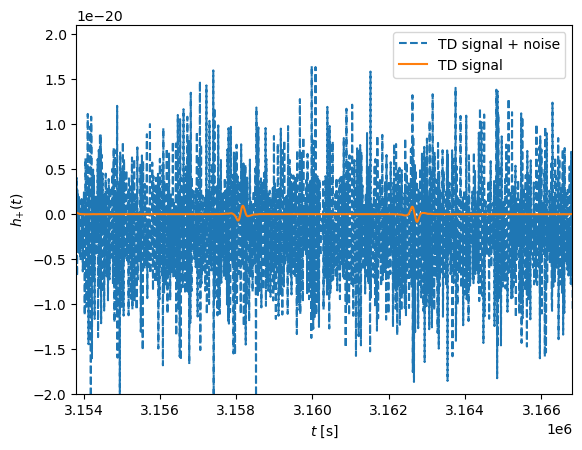

In [18]:
plt.plot(time_array, data_channels_td_noise.real,'--' ,label='TD signal + noise')
plt.plot(time_array, chans[0],label='TD signal')
plt.ylabel(r'$h_{+}(t)$')
plt.xlabel(r'$t$ [s]')

t0 = time_array[-1]*0.1
space_t = 1.3*10e3
plt.xlim([t0,(t0+space_t)])
plt.ylim([-2e-20, 2.1e-20])
#plt.ylim([-1.275e-17, -1.25e-9])
plt.legend()
plt.show()

It oscillates around zero (every realization)